In [11]:
import os
import json
import glob
from tabulate import tabulate

In [12]:
def show_results_table(
    results_base_path="tnqeet/dotting_models/ngrams/evaluation_results/val_dataset",
    models_path="tnqeet/dotting_models/ngrams/trained_models",
    sort_by="wer",
    ascending=True,
    print_rows=False,
):
    """
    Display results table for ngram dotting models.

    Args:
        results_base_path: Base path to results directory
        models_path: Path to trained models directory
        sort_by: Column to sort by (ngram, beam_size, model_size_gb, inference_time, wer, cer, doer)
        ascending: Sort order (True for ascending, False for descending)
    """
    # Get model sizes
    model_sizes = {}
    for model_file in glob.glob(os.path.join(models_path, "ngrams_*.binary")):
        ngram = int(os.path.basename(model_file).split("_")[1].split(".")[0])
        size_gb = os.path.getsize(model_file) / (1024**3)
        model_sizes[ngram] = size_gb

    # Collect all results
    rows = []
    for beam_dir in glob.glob(os.path.join(results_base_path, "beam_size_*")):
        beam_size = int(os.path.basename(beam_dir).split("_")[-1])

        for result_file in glob.glob(os.path.join(beam_dir, "ngrams_*.json")):
            ngram = int(os.path.basename(result_file).split("_")[1].split(".")[0])

            with open(result_file, "r", encoding="utf-8") as f:
                results = json.load(f)

            if results:
                # Parse dotting_time which is stored as string like "0:00:00.001234"
                def parse_time(time_str):
                    try:
                        if isinstance(time_str, str) and ":" in time_str:
                            parts = time_str.split(":")
                            hours, minutes = int(parts[0]), int(parts[1])
                            seconds = float(parts[2])
                            return hours * 3600 + minutes * 60 + seconds
                        return float(time_str)
                    except:
                        return 0.0

                avg_time = sum(parse_time(r["dotting_time"]) for r in results) / len(results)
                avg_wer = sum(r["wer"] for r in results) / len(results)
                avg_cer = sum(r["cer"] for r in results) / len(results)
                avg_doer = sum(r["doer"] for r in results) / len(results)

                rows.append(
                    [
                        ngram,
                        beam_size,
                        f"{model_sizes.get(ngram, 0):.3f}",
                        f"{avg_time:.4f}",
                        f"{avg_wer:.4f}",
                        f"{avg_cer:.4f}",
                        f"{avg_doer:.4f}",
                    ]
                )

    # Sort results
    sort_idx = {
        "ngram": 0,
        "beam_size": 1,
        "model_size_gb": 2,
        "inference_time": 3,
        "wer": 4,
        "cer": 5,
        "doer": 6,
    }[sort_by]

    rows.sort(key=lambda x: float(x[sort_idx]) if sort_idx > 1 else int(x[sort_idx]), reverse=not ascending)

    headers = ["NGram", "Beam Size", "Model Size (GB)", "Inference Time (s)", "WER", "CER", "DOER"]

    if print_rows:
        print(tabulate(rows, headers=headers, tablefmt="grid", floatfmt=".4f"))
    return rows

In [13]:
rows = show_results_table(print_rows=True)

+---------+-------------+-------------------+----------------------+--------+--------+--------+
|   NGram |   Beam Size |   Model Size (GB) |   Inference Time (s) |    WER |    CER |   DOER |
+=========+=============+===================+======================+========+========+========+
|      14 |         100 |           29.2140 |              20.8697 | 0.0243 | 0.0046 | 0.0054 |
+---------+-------------+-------------------+----------------------+--------+--------+--------+
|      14 |          90 |           29.2140 |              18.7031 | 0.0245 | 0.0046 | 0.0054 |
+---------+-------------+-------------------+----------------------+--------+--------+--------+
|      14 |          80 |           29.2140 |              16.6251 | 0.0245 | 0.0046 | 0.0054 |
+---------+-------------+-------------------+----------------------+--------+--------+--------+
|      13 |         100 |           24.2830 |              19.9157 | 0.0248 | 0.0046 | 0.0055 |
+---------+-------------+---------------

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle

In [15]:
def plot_performance_heatmap(rows=None, metric='wer', figsize=(10, 6), max_y=0.33, show_inference_time=False):
    """
    Create heatmap for ngram model performance results.
    
    Args:
        rows: Results from show_results_table function
        metric: Which error metric to plot ('wer', 'cer', 'doer')
        figsize: Figure size tuple
        max_y: Maximum color scale value (default 0.2)
        show_inference_time: If True, show inference time as text annotations
    """
    if rows is None:
        raise ValueError("rows parameter is required")
    
    # Extract data
    ngrams = [int(row[0]) for row in rows]
    beam_sizes = [int(row[1]) for row in rows]
    inference_times = [float(row[3]) for row in rows]
    
    metric_idx = {'wer': 4, 'cer': 5, 'doer': 6}[metric]
    error_rates = [float(row[metric_idx]) for row in rows]
    
    # Create DataFrame
    df = pd.DataFrame({
        'ngram': ngrams,
        'beam_size': beam_sizes,
        'error_rate': error_rates,
        'inference_time': inference_times
    })
    
    # Create pivot tables
    error_heatmap = df.pivot_table(values='error_rate', 
                                   index='beam_size', 
                                   columns='ngram', 
                                   aggfunc='mean')
    
    time_heatmap = df.pivot_table(values='inference_time', 
                                  index='beam_size', 
                                  columns='ngram', 
                                  aggfunc='mean') if show_inference_time else None
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Main heatmap
    im = ax.imshow(error_heatmap.values, cmap='RdYlBu_r', aspect='auto', 
                   vmin=0, vmax=max_y, interpolation='nearest')
    
    # Set ticks and labels
    ax.set_xticks(range(len(error_heatmap.columns)))
    ax.set_xticklabels(error_heatmap.columns)
    ax.set_yticks(range(len(error_heatmap.index)))
    ax.set_yticklabels(error_heatmap.index)
    
    ax.set_xlabel('N-gram Order', fontsize=12)
    ax.set_ylabel('Beam Size', fontsize=12)
    
    title = f'{metric.upper()} Performance Heatmap'
    if show_inference_time:
        title += '\n(Numbers show inference time in seconds)'
    ax.set_title(title, fontsize=14)
    
    # Add annotations
    for i in range(len(error_heatmap.index)):
        for j in range(len(error_heatmap.columns)):
            error_val = error_heatmap.iloc[i, j]
            if not pd.isna(error_val):
                text_color = 'white' if error_val > max_y/2 else 'black'
                
                if show_inference_time and time_heatmap is not None:
                    time_val = time_heatmap.iloc[i, j]
                    if not pd.isna(time_val):
                        ax.text(j, i, f'{time_val:.3f}s', ha='center', va='center', 
                               color=text_color, fontsize=8, weight='bold')
                else:
                    ax.text(j, i, f'{error_val:.3f}', ha='center', va='center', 
                           color=text_color, fontsize=8, weight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label(f'{metric.upper()}', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print best configuration
    best_idx = np.argmin(error_rates)
    print(f"\nBest {metric.upper()}: {error_rates[best_idx]:.4f}")
    print(f"Configuration: {ngrams[best_idx]}-gram, Beam Size: {beam_sizes[best_idx]}")
    print(f"Inference Time: {inference_times[best_idx]:.4f}s")

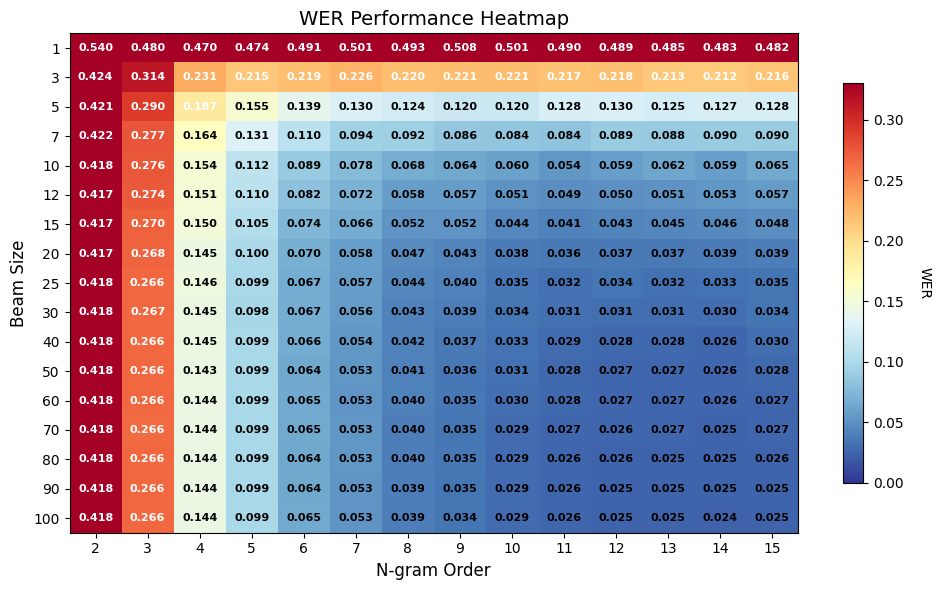


Best WER: 0.0243
Configuration: 14-gram, Beam Size: 100
Inference Time: 20.8697s


In [16]:
plot_performance_heatmap(rows=rows)

In [17]:
def plot_ngram_model_size(rows=rows, figsize=(8, 5), log_scale=False):
    """
    Plot relationship between N-gram order and model size.
    
    Args:
        rows: Results from show_results_table function
        figsize: Figure size tuple
        log_scale: If True, use log scale for y-axis (model size)
    """
    if rows is None:
        raise ValueError("rows parameter is required")
    
    # Extract data
    ngrams = [int(row[0]) for row in rows]
    model_sizes = [float(row[2]) for row in rows]
    
    # Create DataFrame and get unique values
    df = pd.DataFrame({'ngram': ngrams, 'model_size': model_sizes})
    model_size_by_ngram = df.groupby('ngram')['model_size'].first().sort_index()
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot as both line and bars for clarity
    x_pos = np.arange(len(model_size_by_ngram))
    bars = ax.bar(x_pos, model_size_by_ngram.values, alpha=0.7, 
                  color='lightblue', edgecolor='navy', linewidth=1.5)
    
    # Add line plot
    ax.plot(x_pos, model_size_by_ngram.values, 'ro-', linewidth=2, 
            markersize=8, color='darkred', alpha=0.8)
    
    # Customize axes
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_size_by_ngram.index)
    ax.set_xlabel('N-gram Order', fontsize=12)
    ax.set_ylabel('Model Size (GB)', fontsize=12)
    
    if log_scale:
        ax.set_yscale('log')
        ax.set_ylabel('Model Size (GB) - Log Scale', fontsize=12)
    
    ax.set_title('Model Size vs N-gram Order', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (ngram, size) in enumerate(model_size_by_ngram.items()):
        ax.text(i, size + max(model_size_by_ngram) * 0.02, f'{size:.2f}', 
                ha='center', va='bottom', fontsize=10, weight='bold')
    
    # Add growth rate annotation
    if len(model_size_by_ngram) > 1:
        sizes = model_size_by_ngram.values
        avg_growth = np.mean([sizes[i]/sizes[i-1] for i in range(1, len(sizes))])
        ax.text(0.02, 0.98, f'Avg Growth Factor: {avg_growth:.2f}x', 
                transform=ax.transAxes, fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nModel Size Summary:")
    print(f"Smallest: {min(model_size_by_ngram):.3f} GB ({model_size_by_ngram.idxmin()}-gram)")
    print(f"Largest: {max(model_size_by_ngram):.3f} GB ({model_size_by_ngram.idxmax()}-gram)")
    print(f"Size range: {max(model_size_by_ngram)/min(model_size_by_ngram):.1f}x difference")

/tmp/ipykernel_1642467/878121454.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_pos, model_size_by_ngram.values, 'ro-', linewidth=2,


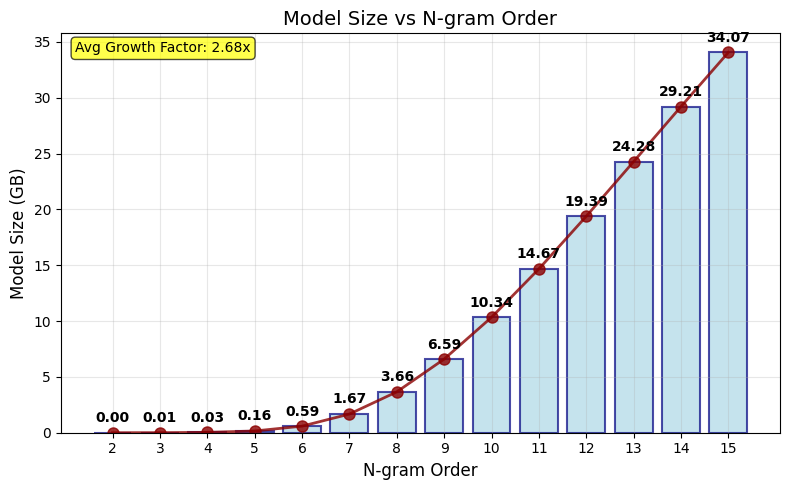


Model Size Summary:
Smallest: 0.001 GB (2-gram)
Largest: 34.072 GB (15-gram)
Size range: 34072.0x difference


In [18]:
plot_ngram_model_size(rows=rows)

In [19]:
def plot_beam_inference_time(rows=rows, figsize=(10, 6), log_scale=False):
    """
    Plot relationship between beam size and inference time for each n-gram.
    
    Args:
        rows: Results from show_results_table function
        figsize: Figure size tuple
        log_scale: If True, use log scale for y-axis (inference time)
    """
    if rows is None:
        raise ValueError("rows parameter is required")
    
    # Extract data
    ngrams = [int(row[0]) for row in rows]
    beam_sizes = [int(row[1]) for row in rows]
    inference_times = [float(row[3]) for row in rows]
    
    # Create DataFrame
    df = pd.DataFrame({
        'ngram': ngrams,
        'beam_size': beam_sizes,
        'inference_time': inference_times
    })
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique n-grams and create color map
    unique_ngrams = sorted(df['ngram'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_ngrams)))
    
    # Plot line for each n-gram
    for i, ngram in enumerate(unique_ngrams):
        ngram_data = df[df['ngram'] == ngram].sort_values('beam_size')
        
        ax.plot(ngram_data['beam_size'], ngram_data['inference_time'], 
                'o-', color=colors[i], linewidth=2, markersize=6,
                label=f'{ngram}-gram', alpha=0.8)
    
    # Customize axes
    ax.set_xlabel('Beam Size', fontsize=12)
    ax.set_ylabel('Inference Time (seconds)', fontsize=12)
    
    if log_scale:
        ax.set_yscale('log')
        ax.set_ylabel('Inference Time (seconds) - Log Scale', fontsize=12)
    
    ax.set_title('Inference Time vs Beam Size by N-gram Order', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(title='N-gram Order', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set x-axis to show all beam sizes
    all_beam_sizes = sorted(df['beam_size'].unique())
    ax.set_xticks(all_beam_sizes)
    
    # Rotate x-labels if too many
    if len(all_beam_sizes) > 10:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nInference Time Summary:")
    for ngram in unique_ngrams:
        ngram_data = df[df['ngram'] == ngram]
        min_time = ngram_data['inference_time'].min()
        max_time = ngram_data['inference_time'].max()
        min_beam = ngram_data.loc[ngram_data['inference_time'].idxmin(), 'beam_size']
        max_beam = ngram_data.loc[ngram_data['inference_time'].idxmax(), 'beam_size']
        
        print(f"{ngram}-gram: {min_time:.4f}s (beam={min_beam}) to {max_time:.4f}s (beam={max_beam})")
    
    # Find fastest overall
    fastest_idx = df['inference_time'].idxmin()
    fastest = df.loc[fastest_idx]
    print(f"\nFastest: {fastest['inference_time']:.4f}s ({fastest['ngram']}-gram, beam={fastest['beam_size']})")

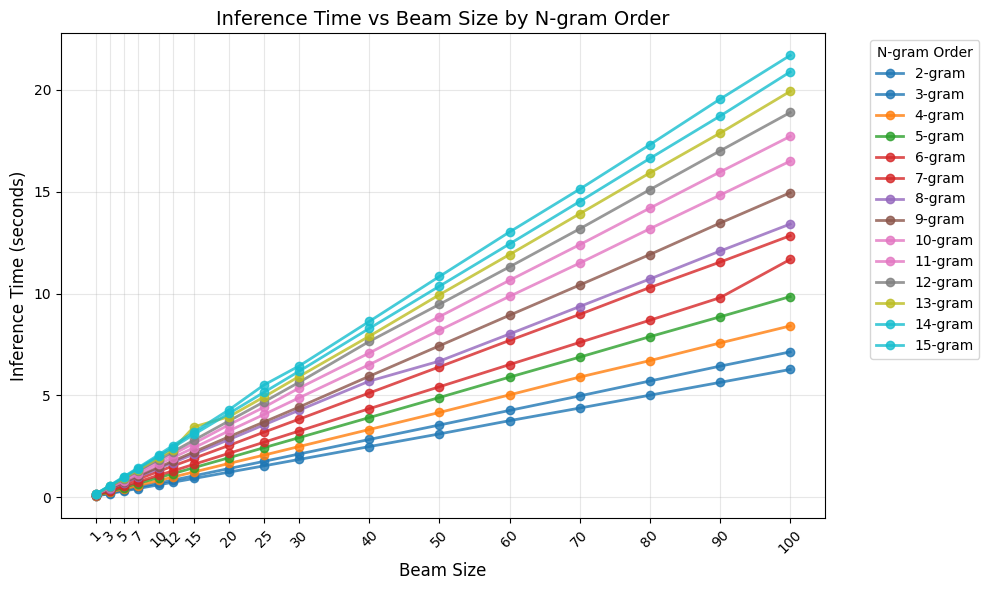


Inference Time Summary:
2-gram: 0.0620s (beam=1) to 6.2747s (beam=100)
3-gram: 0.0703s (beam=1) to 7.1352s (beam=100)
4-gram: 0.0827s (beam=1) to 8.4097s (beam=100)
5-gram: 0.0972s (beam=1) to 9.8486s (beam=100)
6-gram: 0.1079s (beam=1) to 11.6720s (beam=100)
7-gram: 0.1259s (beam=1) to 12.8335s (beam=100)
8-gram: 0.1373s (beam=1) to 13.4065s (beam=100)
9-gram: 0.1374s (beam=1) to 14.9438s (beam=100)
10-gram: 0.1443s (beam=1) to 16.4924s (beam=100)
11-gram: 0.1500s (beam=1) to 17.7066s (beam=100)
12-gram: 0.1531s (beam=1) to 18.8780s (beam=100)
13-gram: 0.1553s (beam=1) to 19.9157s (beam=100)
14-gram: 0.1572s (beam=1) to 20.8697s (beam=100)
15-gram: 0.1589s (beam=1) to 21.6794s (beam=100)

Fastest: 0.0620s (2.0-gram, beam=1.0)


In [20]:
plot_beam_inference_time(rows=rows)